<a href="https://colab.research.google.com/github/Pathway2008/Weblog/blob/main/add_choice_col.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Weblog/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Weblog/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Weblog/sample_submission.csv')

In [8]:
train.drop(['sessionID','userID'],axis=1,inplace=True)
test.drop(['sessionID','userID'],axis=1,inplace=True)

In [9]:
import warnings
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
warnings.filterwarnings('ignore')
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [22]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
object_columns = train.drop(columns=['TARGET']).select_dtypes(include='object')
for feature in object_columns.columns:
    le = LabelEncoder()

    # Convert the column to string type
    train[feature] = train[feature].astype(str)
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    # Make sure the test set has the same data type
    test[feature] = test[feature].astype(str)

    # Handle unseen labels in the test set
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)

    test[feature] = le.transform(test[feature])

In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [3]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from math import sqrt
from sklearn.metrics import make_scorer, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.model_selection import KFold
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [5]:
def rmse_scorer(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               252289 non-null  float64
 1   browser              252289 non-null  object 
 2   OS                   252289 non-null  object 
 3   device               252289 non-null  object 
 4   new                  252289 non-null  int64  
 5   quality              252289 non-null  float64
 6   duration             252289 non-null  float64
 7   bounced              252289 non-null  int64  
 8   transaction          252289 non-null  float64
 9   transaction_revenue  252289 non-null  float64
 10  continent            252289 non-null  object 
 11  subcontinent         252289 non-null  object 
 12  country              252289 non-null  object 
 13  traffic_source       252289 non-null  object 
 14  traffic_medium       252289 non-null  object 
 15  keyword          

In [10]:
train.head()

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000


In [15]:
train[train['transaction']<train['transaction_revenue']]

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
118,17.0,Chrome,Macintosh,desktop,1,64.0,1318.0,0,1.0,26620800.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
352,18.0,Chrome,Windows,desktop,0,68.0,668.0,0,1.0,53798560.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
1499,22.0,Chrome,Windows,desktop,1,28.0,548.0,0,1.0,60869120.0,Americas,Northern America,United States,google,organic,Category8,NaN
1862,16.0,Chrome,Chrome OS,desktop,0,91.0,883.0,0,1.0,7363200.0,Americas,Northern America,United States,(direct),(none),NaN,Category6_Path_0008
2764,20.0,Chrome,Android,mobile,1,46.0,1735.0,0,1.0,70771680.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251856,30.0,Chrome,Android,mobile,1,42.0,3526.0,0,1.0,16982560.0,Americas,Northern America,United States,google,organic,Category8,NaN
251972,15.0,Chrome,Macintosh,desktop,0,74.0,495.0,0,1.0,22835360.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252017,34.0,Chrome,Macintosh,desktop,0,69.0,723.0,0,1.0,156052640.0,Americas,Northern America,United States,google,organic,Category8,NaN
252036,43.0,Chrome,Windows,desktop,0,66.0,852.0,0,1.0,20739680.0,Americas,Northern America,United States,google,organic,Category8,NaN


In [18]:
train[train['transaction']>train['transaction_revenue']]

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
240818,15.0,Chrome,Windows,desktop,0,62.0,1433.0,0,1.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
247846,24.0,Chrome,Windows,desktop,0,60.0,3258.0,0,1.0,0.0,Americas,Northern America,Canada,(direct),(none),NaN,NaN
248299,32.0,Chrome,Windows,desktop,0,66.0,4083.0,0,1.0,0.0,Americas,Northern America,Canada,(direct),(none),NaN,NaN
248374,26.0,Chrome,Windows,desktop,0,68.0,1282.0,0,1.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
248716,78.0,Chrome,Windows,desktop,0,75.0,2263.0,0,1.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN
248986,70.0,Chrome,Macintosh,desktop,0,85.0,4589.0,0,1.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,NaN


In [16]:
train[train['transaction']<train['transaction_revenue']]['TARGET'].describe()

count    2202.000000
mean       21.760218
std        13.568568
min         3.000000
25%        13.000000
50%        18.000000
75%        26.000000
max       171.000000
Name: TARGET, dtype: float64

In [17]:
train[train['transaction']>train['transaction_revenue']]['TARGET'].describe()

count     6.000000
mean     40.833333
std      26.384970
min      15.000000
25%      24.500000
50%      29.000000
75%      60.500000
max      78.000000
Name: TARGET, dtype: float64

In [21]:
train[(train['transaction']==0)&(train['transaction_revenue']==0)]

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252284,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Northern Europe,United Kingdom,youtube.com,referral,NaN,Category5_Path_0032
252285,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252286,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252287,1.0,Android Webview,Android,mobile,1,1.0,28.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0018


In [23]:
train['trans'] = train.apply(lambda row: 0 if row['transaction'] == 0 else row['transaction_revenue'] / row['transaction'], axis=1)
train['duration/quality'] = train['duration'] / train['quality']
train['duration*quality'] = train['duration'] * train['quality']

In [59]:
test['trans'] = test.apply(lambda row: 0 if row['transaction'] == 0 else row['transaction_revenue'] / row['transaction'], axis=1)
test['duration/quality'] = test['duration'] / test['quality']
test['duration*quality'] = test['duration'] * test['quality']

In [24]:
from sklearn.model_selection import train_test_split
X = train.drop(['TARGET'], axis=1)#(dev,trm,key
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

In [43]:
#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)
xgb_predictions = xgb_model.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))
xgb_scores = cross_val_score(xgb_model, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

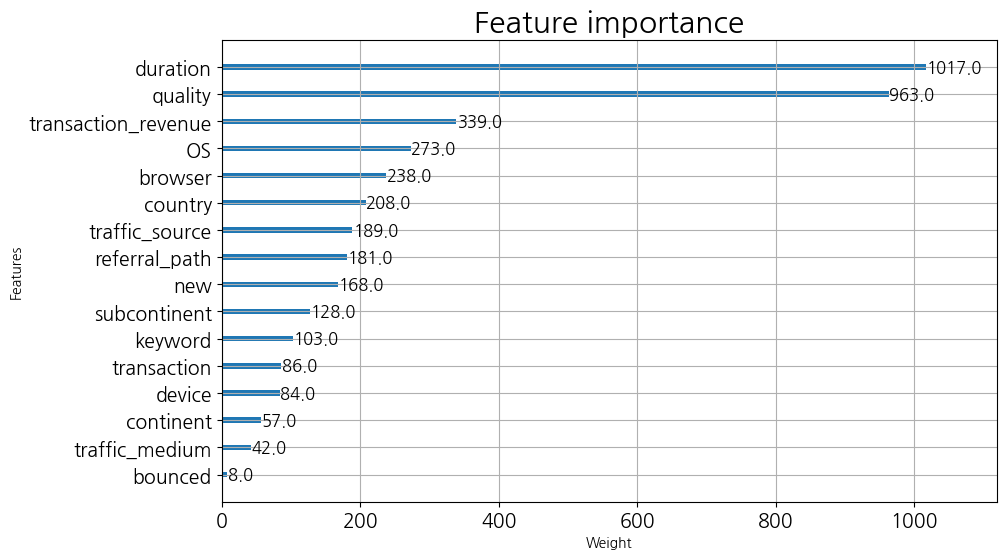

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.rc('axes', labelsize=10)

xgb.plot_importance(xgb_model, importance_type='weight', xlabel='Weight',ax=ax)
for text in ax.texts:
    text.set_size(12)
plt.show()

In [44]:
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.8491038194831644
XGBoost test RMSE: 2.745348382572756



In [46]:
#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

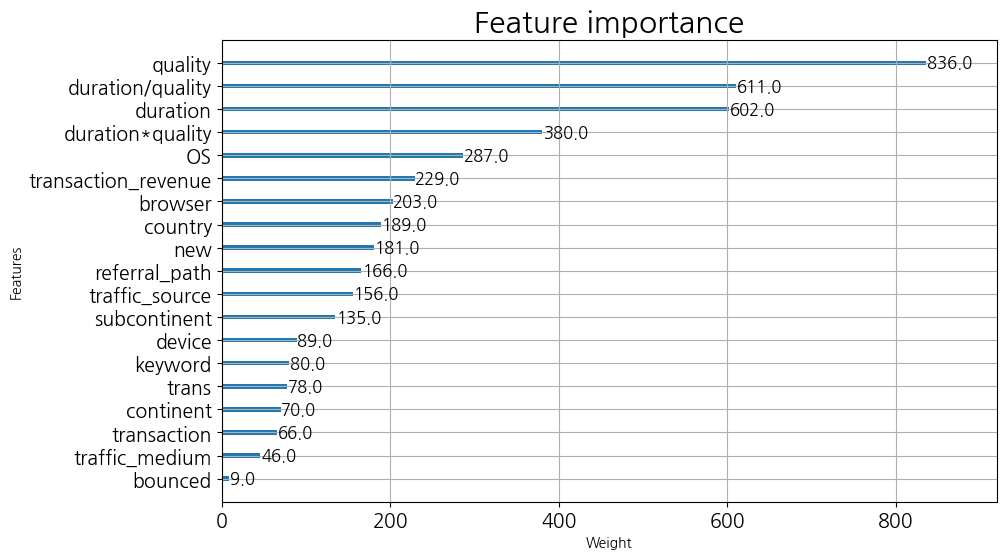

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.rc('axes', labelsize=10)

xgb.plot_importance(xgb_model, importance_type='weight', xlabel='Weight',ax=ax)
for text in ax.texts:
    text.set_size(12)
plt.show()

In [28]:
#new col3
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

XGBoost Cross-Validation RMSE: 2.7774646486526167
XGBoost test RMSE: 2.8362344027389375



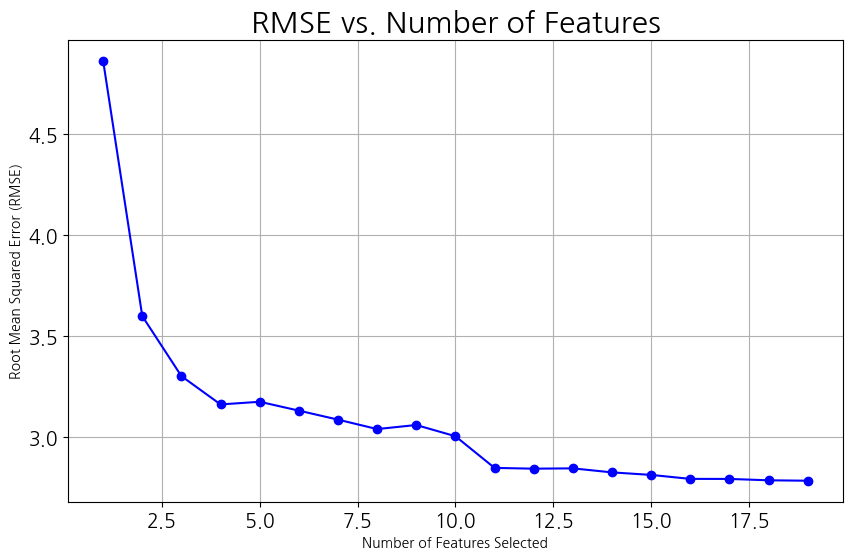

In [48]:
rfecv = RFECV(estimator=xgb_model, step=1, cv=kf, scoring='neg_mean_squared_error')

rfecv.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         np.sqrt(-rfecv.cv_results_['mean_test_score']),
         marker='o', linestyle='-', color='b')
plt.title('RMSE vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.show()

In [47]:
import numpy as np
from sklearn.feature_selection import RFECV
# xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)

rfecv = RFECV(estimator=xgb_model, step=1, cv=kf, scoring='neg_mean_squared_error')

# Fit RFECV on the training data
rfecv.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:", selected_features)

# Transform the training and testing sets using only the selected features
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

# Now, you can train your XGBoost model using the selected features
xgb_model.fit(X_train_selected, y_train)
xgb_scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
y_pred = xgb_model.predict(X_test_selected)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("xgb_scores:", xgb_scores.mean())
print("RMSE:", rmse)

Selected Features: Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'transaction_revenue', 'continent', 'subcontinent',
       'country', 'traffic_source', 'traffic_medium', 'keyword',
       'referral_path', 'trans', 'duration/quality', 'duration*quality'],
      dtype='object')
xgb_scores: 2.7774646486526167
RMSE: 2.8362344027389375


# vs voting

In [50]:
# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)
rf_predictions = rf_model.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))
rf_scores = cross_val_score(rf_model, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)
et_predictions = et_model.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))
et_scores = cross_val_score(et_model, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)
xgb_predictions = xgb_model.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))
xgb_scores = cross_val_score(xgb_model, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

#cat
cat_model = CatBoostRegressor(random_seed=43, l2_leaf_reg=4, verbose=0)
cat_model.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)
cat_predictions = cat_model.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))
cat_scores = cross_val_score(cat_model, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
lgb_model.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)
lgb_predictions = lgb_model.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))
lgb_scores = cross_val_score(lgb_model, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [51]:
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse}")

Random Forest Cross-Validation RMSE: 2.8772603501599288
RF test RMSE: 2.787345470753536

Extra Trees Cross-Validation RMSE: 2.9151268400916703
ET test RMSE: 2.9101033585414218

XGBoost Cross-Validation RMSE: 2.8491038194831644
XGBoost test RMSE: 2.745348382572756

CatBoost Cross-Validation RMSE: 2.7631369388930205
CatBoost test RMSE: 2.7357731787807276

Cross-validated LightGBM scores: 2.750722150406905
LightGBM RMSE on test set: 2.7743799222694636


In [52]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)

voting_predictions = voting_regressor.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1350
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

In [53]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.721710996963167
VotingRegressor test RMSE: 2.6907786729299086


In [54]:
# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train, y_train)
et_predictions = et_model.predict(X_test)
et_scores = cross_val_score(et_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

#cat
cat_model = CatBoostRegressor(random_seed=43, l2_leaf_reg=4, verbose=0)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 19
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 19
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [55]:
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse}")

Random Forest Cross-Validation RMSE: 2.851839912551597
RF test RMSE: 2.9326420510552555

Extra Trees Cross-Validation RMSE: 2.8823727958727403
ET test RMSE: 2.928257013400541

XGBoost Cross-Validation RMSE: 2.7774646486526167
XGBoost test RMSE: 2.8362344027389375

CatBoost Cross-Validation RMSE: 2.7504343169355705
CatBoost test RMSE: 2.7611192918561107

Cross-validated LightGBM scores: 2.737463870306459
LightGBM RMSE on test set: 2.7340070041664295


In [56]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train, y_train)

voting_predictions = voting_regressor.predict(X_test)

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 19
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 19
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [57]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.7139901252937033
VotingRegressor test RMSE: 2.727571224650186


In [62]:
# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train, y_train)
et_predictions = et_model.predict(X_test)
et_scores = cross_val_score(et_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

#xgb
xgb_model = xgb.XGBRegressor(random_state=43)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

#cat
cat_model = CatBoostRegressor(random_seed=43)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model = LGBMRegressor(random_state=43)
lgb_model.fit(X_train, y_train)
lgb_predictions = lgb_model.predict(X_test)
lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
40:	learn: 2.8818224	total: 682ms	remaining: 15.9s
41:	learn: 2.8747584	total: 696ms	remaining: 15.9s
42:	learn: 2.8685470	total: 710ms	remaining: 15.8s
43:	learn: 2.8634121	total: 725ms	remaining: 15.8s
44:	learn: 2.8598228	total: 740ms	remaining: 15.7s
45:	learn: 2.8536217	total: 756ms	remaining: 15.7s
46:	learn: 2.8531646	total: 768ms	remaining: 15.6s
47:	learn: 2.8520677	total: 781ms	remaining: 15.5s
48:	learn: 2.8463935	total: 795ms	remaining: 15.4s
49:	learn: 2.8439064	total: 809ms	remaining: 15.4s
50:	learn: 2.8430329	total: 822ms	remaining: 15.3s
51:	learn: 2.8383829	total: 836ms	remaining: 15.2s
52:	learn: 2.8373392	total: 850ms	remaining: 15.2s
53:	learn: 2.8370350	total: 863ms	remaining: 15.1s
54:	learn: 2.8318093	total: 879ms	remaining: 15.1s
55:	learn: 2.8262305	total: 896ms	remaining: 15.1s
56:	learn: 2.8227003	total: 911ms	remaining: 15.1s
57:	learn: 2.8224585	total: 923ms	remaining: 15s
58:	learn: 2.8211748	total: 935ms	remaining: 14.

In [63]:
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse}")

Random Forest Cross-Validation RMSE: 2.851839912551597
RF test RMSE: 2.9326420510552555

Extra Trees Cross-Validation RMSE: 2.8823727958727403
ET test RMSE: 2.928257013400541

XGBoost Cross-Validation RMSE: 2.8370085530500093
XGBoost test RMSE: 2.874057308430686

CatBoost Cross-Validation RMSE: 2.7388401404295335
CatBoost test RMSE: 2.744493195345724

Cross-validated LightGBM scores: 2.7325711104254102
LightGBM RMSE on test set: 2.725954592506087


In [64]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train, y_train)

voting_predictions = voting_regressor.predict(X_test)

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
34:	learn: 2.9282686	total: 560ms	remaining: 15.4s
35:	learn: 2.9201676	total: 573ms	remaining: 15.4s
36:	learn: 2.9083851	total: 589ms	remaining: 15.3s
37:	learn: 2.9004048	total: 607ms	remaining: 15.4s
38:	learn: 2.8930522	total: 635ms	remaining: 15.7s
39:	learn: 2.8871984	total: 651ms	remaining: 15.6s
40:	learn: 2.8818224	total: 664ms	remaining: 15.5s
41:	learn: 2.8747584	total: 678ms	remaining: 15.5s
42:	learn: 2.8685470	total: 691ms	remaining: 15.4s
43:	learn: 2.8634121	total: 707ms	remaining: 15.4s
44:	learn: 2.8598228	total: 723ms	remaining: 15.3s
45:	learn: 2.8536217	total: 736ms	remaining: 15.3s
46:	learn: 2.8531646	total: 749ms	remaining: 15.2s
47:	learn: 2.8520677	total: 762ms	remaining: 15.1s
48:	learn: 2.8463935	total: 777ms	remaining: 15.1s
49:	learn: 2.8439064	total: 791ms	remaining: 15s
50:	learn: 2.8430329	total: 803ms	remaining: 14.9s
51:	learn: 2.8383829	total: 820ms	remaining: 15s
52:	learn: 2.8373392	total: 834ms	remaining: 14.9s

In [65]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.7190219738934056
VotingRegressor test RMSE: 2.7185959333044845


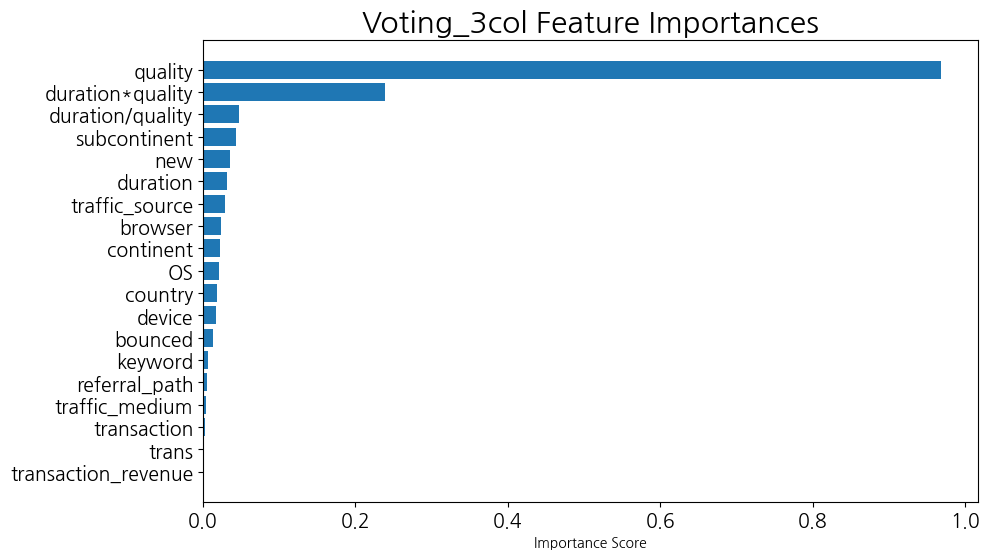

In [71]:
from sklearn.inspection import permutation_importance
feature_names = X_train.columns
# Fit permutation importance on the ensemble model
perm_importance = permutation_importance(voting_regressor, X_test, y_test, n_repeats=30, random_state=43)

# Get feature importances from permutation importance
feature_importances = perm_importance.importances_mean

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance')

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Voting_3col Feature Importances')
plt.show()

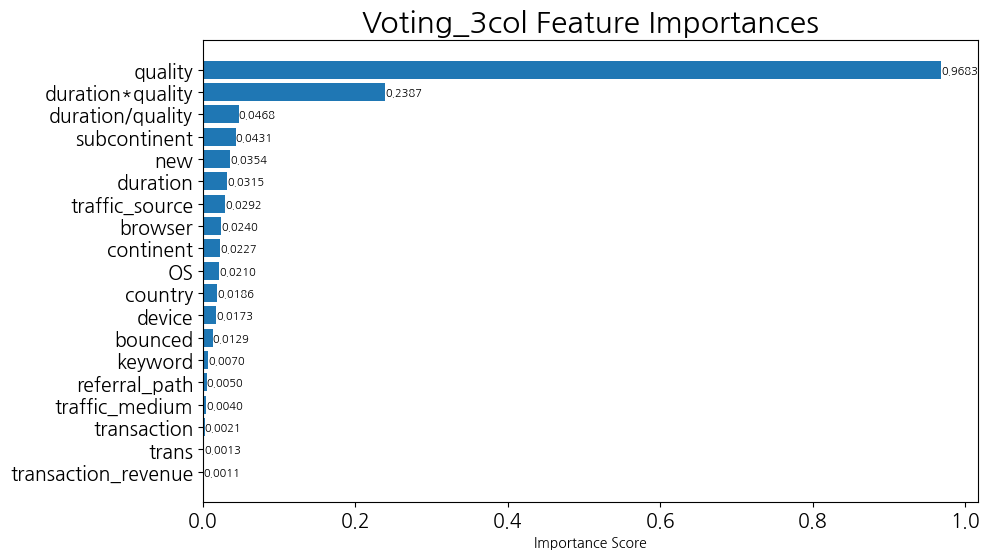

In [72]:
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Voting_3col Feature Importances')

# Add scores as annotations
for bar, score in zip(bars, importance_df['Importance']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center', fontsize=8)

plt.show()

In [60]:
voting_predictions = voting_regressor.predict(test)
neg = [x for x in voting_predictions if x < 0]
neg

[]

In [61]:
sub['TARGET'] = voting_predictions
sub.to_csv('newcol3.csv',index=False)

In [ ]:
'''
# lambda
Random Forest Cross-Validation RMSE: 2.8772603501599288
RF test RMSE: 2.787345470753536

Extra Trees Cross-Validation RMSE: 2.9151268400916703
ET test RMSE: 2.9101033585414218

XGBoost Cross-Validation RMSE: 2.8491038194831644
XGBoost test RMSE: 2.745348382572756

CatBoost Cross-Validation RMSE: 2.7631369388930205
CatBoost test RMSE: 2.7357731787807276

Cross-validated LightGBM scores: 2.750722150406905
LightGBM RMSE on test set: 2.7743799222694636

VotingRegressor Cross-Validation RMSE: 2.721710996963167
VotingRegressor test RMSE: 2.6907786729299086

# lambda+3col
Random Forest Cross-Validation RMSE: 2.851839912551597
RF test RMSE: 2.9326420510552555

Extra Trees Cross-Validation RMSE: 2.8823727958727403
ET test RMSE: 2.928257013400541

XGBoost Cross-Validation RMSE: 2.7774646486526167
XGBoost test RMSE: 2.8362344027389375

CatBoost Cross-Validation RMSE: 2.7504343169355705
CatBoost test RMSE: 2.7611192918561107

Cross-validated LightGBM scores: 2.737463870306459
LightGBM RMSE on test set: 2.7340070041664295

VotingRegressor Cross-Validation RMSE: 2.7139901252937033
VotingRegressor test RMSE: 2.727571224650186

3col
Random Forest Cross-Validation RMSE: 2.851839912551597
RF test RMSE: 2.9326420510552555

Extra Trees Cross-Validation RMSE: 2.8823727958727403
ET test RMSE: 2.928257013400541

XGBoost Cross-Validation RMSE: 2.8370085530500093
XGBoost test RMSE: 2.874057308430686

CatBoost Cross-Validation RMSE: 2.7388401404295335
CatBoost test RMSE: 2.744493195345724

Cross-validated LightGBM scores: 2.7325711104254102
LightGBM RMSE on test set: 2.725954592506087

VotingRegressor Cross-Validation RMSE: 2.7190219738934056
VotingRegressor test RMSE: 2.7185959333044845
'''

# VotingRegressor Cross-Validation RMSE: 2.726586620718117
# VotingRegressor test RMSE: 2.7116253956345284

In [73]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train.drop(['trans','transaction_revenue'],axis=1), y_train)

voting_predictions = voting_regressor.predict(X_test.drop(['trans','transaction_revenue'],axis=1))

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train.drop(['trans','transaction_revenue'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
34:	learn: 2.9209930	total: 535ms	remaining: 14.7s
35:	learn: 2.9180633	total: 547ms	remaining: 14.6s
36:	learn: 2.9113203	total: 560ms	remaining: 14.6s
37:	learn: 2.9057109	total: 572ms	remaining: 14.5s
38:	learn: 2.9044421	total: 585ms	remaining: 14.4s
39:	learn: 2.9008566	total: 598ms	remaining: 14.4s
40:	learn: 2.8980964	total: 615ms	remaining: 14.4s
41:	learn: 2.8934658	total: 627ms	remaining: 14.3s
42:	learn: 2.8882473	total: 643ms	remaining: 14.3s
43:	learn: 2.8811521	total: 659ms	remaining: 14.3s
44:	learn: 2.8798523	total: 671ms	remaining: 14.2s
45:	learn: 2.8736625	total: 684ms	remaining: 14.2s
46:	learn: 2.8698286	total: 697ms	remaining: 14.1s
47:	learn: 2.8677889	total: 710ms	remaining: 14.1s
48:	learn: 2.8638292	total: 723ms	remaining: 14s
49:	learn: 2.8614140	total: 736ms	remaining: 14s
50:	learn: 2.8555813	total: 749ms	remaining: 13.9s
51:	learn: 2.8499327	total: 762ms	remaining: 13.9s
52:	learn: 2.8483044	total: 774ms	remaining: 13.8s

In [74]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.726586620718117
VotingRegressor test RMSE: 2.7116253956345284


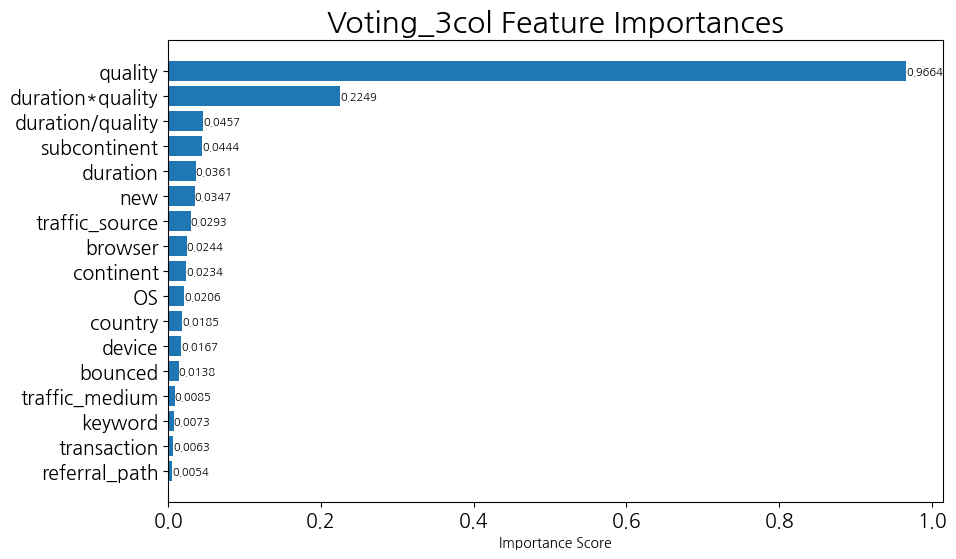

In [81]:
from sklearn.inspection import permutation_importance
feature_names = X_train.drop(['trans','transaction_revenue'],axis=1).columns
# Fit permutation importance on the ensemble model
perm_importance = permutation_importance(voting_regressor, X_test.drop(['trans','transaction_revenue'],axis=1), y_test, n_repeats=30, random_state=43)

# Get feature importances from permutation importance
feature_importances = perm_importance.importances_mean

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance')

plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance Score')
plt.title('Voting_3col Feature Importances')

# Add scores as annotations
for bar, score in zip(bars, importance_df['Importance']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{score:.4f}', va='center', fontsize=8)

plt.show()

In [88]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176602 entries, 79382 to 14148
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   browser              176602 non-null  int64  
 1   OS                   176602 non-null  int64  
 2   device               176602 non-null  int64  
 3   new                  176602 non-null  int64  
 4   quality              176602 non-null  float64
 5   duration             176602 non-null  float64
 6   bounced              176602 non-null  int64  
 7   transaction          176602 non-null  float64
 8   transaction_revenue  176602 non-null  float64
 9   continent            176602 non-null  int64  
 10  subcontinent         176602 non-null  int64  
 11  country              176602 non-null  int64  
 12  traffic_source       176602 non-null  int64  
 13  traffic_medium       176602 non-null  int64  
 14  keyword              176602 non-null  int64  
 15  referral_path 

In [83]:
# from sklearn.ensemble import VotingRegressor
# voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train.drop(['trans','transaction_revenue','transaction'],axis=1), y_train)

voting_predictions = voting_regressor.predict(X_test.drop(['trans','transaction_revenue','transaction'],axis=1))

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train.drop(['trans','transaction_revenue','transaction'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
34:	learn: 2.8178563	total: 631ms	remaining: 17.4s
35:	learn: 2.8106313	total: 649ms	remaining: 17.4s
36:	learn: 2.8042727	total: 663ms	remaining: 17.2s
37:	learn: 2.7964003	total: 676ms	remaining: 17.1s
38:	learn: 2.7895841	total: 690ms	remaining: 17s
39:	learn: 2.7841607	total: 703ms	remaining: 16.9s
40:	learn: 2.7789197	total: 718ms	remaining: 16.8s
41:	learn: 2.7698715	total: 734ms	remaining: 16.7s
42:	learn: 2.7638012	total: 749ms	remaining: 16.7s
43:	learn: 2.7581754	total: 763ms	remaining: 16.6s
44:	learn: 2.7517980	total: 778ms	remaining: 16.5s
45:	learn: 2.7472895	total: 790ms	remaining: 16.4s
46:	learn: 2.7426421	total: 808ms	remaining: 16.4s
47:	learn: 2.7347481	total: 823ms	remaining: 16.3s
48:	learn: 2.7297825	total: 839ms	remaining: 16.3s
49:	learn: 2.7241912	total: 852ms	remaining: 16.2s
50:	learn: 2.7209877	total: 866ms	remaining: 16.1s
51:	learn: 2.7160474	total: 880ms	remaining: 16.1s
52:	learn: 2.7106322	total: 896ms	remaining: 16s

In [84]:
# 'trans','transaction_revenue','transaction'
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.7784756551258654
VotingRegressor test RMSE: 2.7283453293737243


In [90]:
# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train.drop(['browser','bounced','device','trans','duration/quality','duration*quality'],axis=1), y_train)
rf_predictions = rf_model.predict(X_test.drop(['browser','bounced','device','trans','duration/quality','duration*quality'],axis=1))
rf_scores = cross_val_score(rf_model, X_train.drop(['browser','bounced','device','trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train.drop(['device', 'keyword', 'transaction_revenue','trans','duration/quality','duration*quality'],axis=1), y_train)
et_predictions = et_model.predict(X_test.drop(['device', 'keyword', 'transaction_revenue','trans','duration/quality','duration*quality'],axis=1))
et_scores = cross_val_score(et_model, X_train.drop(['device', 'keyword', 'transaction_revenue','trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train.drop(['device', 'subcontinent', 'keyword','trans','duration/quality','duration*quality'],axis=1), y_train)
xgb_predictions = xgb_model.predict(X_test.drop(['device', 'subcontinent', 'keyword','trans','duration/quality','duration*quality'],axis=1))
xgb_scores = cross_val_score(xgb_model, X_train.drop(['device', 'subcontinent', 'keyword','trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

#cat
cat_model = CatBoostRegressor(random_seed=43, l2_leaf_reg=4, verbose=0)
cat_model.fit(X_train.drop(['browser', 'OS', 'bounced','trans','duration/quality','duration*quality'],axis=1), y_train)
cat_predictions = cat_model.predict(X_test.drop(['browser', 'OS', 'bounced','trans','duration/quality','duration*quality'],axis=1))
cat_scores = cross_val_score(cat_model, X_train.drop(['browser', 'OS', 'bounced','trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
lgb_model.fit(X_train.drop(['device', 'keyword', 'transaction_revenue', 'subcontinent','trans','duration/quality','duration*quality'],axis=1), y_train)
lgb_predictions = lgb_model.predict(X_test.drop(['device', 'keyword', 'transaction_revenue', 'subcontinent','trans','duration/quality','duration*quality'],axis=1))
lgb_scores = cross_val_score(lgb_model, X_train.drop(['device', 'keyword', 'transaction_revenue', 'subcontinent','trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse = rmse_scorer(y_test, lgb_predictions)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011283 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 965
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 12
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 12
[LightGBM] [Info] Start training from score 3.603549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [91]:
# from sklearn.ensemble import VotingRegressor
# voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train)

voting_predictions = voting_regressor.predict(X_test.drop(['trans','duration/quality','duration*quality'],axis=1))

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train.drop(['trans','duration/quality','duration*quality'],axis=1), y_train, cv=kf, scoring=make_scorer(rmse_scorer))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
34:	learn: 2.8411886	total: 522ms	remaining: 14.4s
35:	learn: 2.8350660	total: 534ms	remaining: 14.3s
36:	learn: 2.8345262	total: 544ms	remaining: 14.1s
37:	learn: 2.8261747	total: 557ms	remaining: 14.1s
38:	learn: 2.8174949	total: 570ms	remaining: 14.1s
39:	learn: 2.8139615	total: 583ms	remaining: 14s
40:	learn: 2.8088476	total: 597ms	remaining: 14s
41:	learn: 2.8021247	total: 615ms	remaining: 14s
42:	learn: 2.7951026	total: 629ms	remaining: 14s
43:	learn: 2.7910414	total: 648ms	remaining: 14.1s
44:	learn: 2.7873396	total: 663ms	remaining: 14.1s
45:	learn: 2.7868976	total: 674ms	remaining: 14s
46:	learn: 2.7801642	total: 688ms	remaining: 14s
47:	learn: 2.7786310	total: 700ms	remaining: 13.9s
48:	learn: 2.7772832	total: 712ms	remaining: 13.8s
49:	learn: 2.7713327	total: 726ms	remaining: 13.8s
50:	learn: 2.7666886	total: 740ms	remaining: 13.8s
51:	learn: 2.7642875	total: 753ms	remaining: 13.7s
52:	learn: 2.7613696	total: 765ms	remaining: 13.7s
53:	lea

In [92]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.7211509052639054
VotingRegressor test RMSE: 2.69498367531399


In [87]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.753675919034773
VotingRegressor test RMSE: 2.7185959333044845
